In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.append("../../pipeline/src")
import pickle
import torch
from tqdm import tqdm

In [2]:
plt.rcParams['figure.dpi'] = 50












In [3]:
from utils.metrics import ContactPredictionMetrics
from datamodules.dataset import ProteinSequenceDataset

All seeds set to: 42


In [4]:
dataset = ProteinSequenceDataset.load_from_disk("../../pipeline/output/datasets/val.pt")
with open("../../pipeline/output/predictions/val.pkl", "rb") as f:
    predictions = pickle.load(f)

scorer = ContactPredictionMetrics()

In [5]:
predictions[1]

{'contact_logits': tensor([[[-1.4716, 11.8556,  7.8056,  ..., -4.7818, -4.6964, -4.5137],
          [11.8556,  0.2322, 10.1665,  ..., -4.9877, -5.0036, -4.9065],
          [ 7.8056, 10.1665, -0.3805,  ..., -4.9692, -4.9782, -4.9611],
          ...,
          [-4.7818, -4.9877, -4.9692,  ..., -0.4648, 10.6180, 10.3005],
          [-4.6964, -5.0036, -4.9782,  ..., 10.6180, -1.3665,  9.5783],
          [-4.5137, -4.9065, -4.9611,  ..., 10.3005,  9.5783,  3.4257]],
 
         [[-9.0603,  4.4460,  0.8492,  ..., -4.6465, -4.6465, -4.6465],
          [ 4.4460, -2.6271,  8.8719,  ..., -4.6465, -4.6465, -4.6465],
          [ 0.8492,  8.8719,  0.5469,  ..., -4.6465, -4.6465, -4.6465],
          ...,
          [-4.6465, -4.6465, -4.6465,  ..., -4.6465, -4.6465, -4.6465],
          [-4.6465, -4.6465, -4.6465,  ..., -4.6465, -4.6465, -4.6465],
          [-4.6465, -4.6465, -4.6465,  ..., -4.6465, -4.6465, -4.6465]]]),
 'mask_2d': tensor([[[ True,  True,  True,  ...,  True,  True,  True],
          [

In [6]:
import torch

class PredictionDataset:
    def __init__(self, data: dict[dict]):
        self.data = data

    @classmethod
    def from_batches(cls, batches: list[dict]):
        data = {}
        for batch in batches:
            for contact_logits, mask, metadata in zip(batch["contact_logits"], batch["mask_2d"], batch["metadata"]):
                contact_logits = contact_logits[:metadata['length'], :metadata['length']]
                mask = mask[:metadata['length'], :metadata['length']]
                data[metadata["id"]] = {
                    "contact_logits": contact_logits,
                    "mask_2d": mask,
                    "metadata": metadata,
                }
        return PredictionDataset(data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
prediction_dataset = PredictionDataset.from_batches(predictions)

In [8]:
id_contact_map = {
    item["metadata"]["id"]: {
        "contact_map": torch.tensor(item["distance_map"] < 8, dtype=torch.long),
        "seq_length": item["seq_length"],
        "distance_map": item["distance_map"],
    }
    for item in dataset
}

/tmp/ipykernel_54349/1398106193.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "contact_map": torch.tensor(item["distance_map"] < 8, dtype=torch.long),


In [9]:
metrics = []
for item in tqdm(dataset):
    contact_map = torch.tensor(item["distance_map"] < 8, dtype=torch.long).unsqueeze(0)
    pred = prediction_dataset[item["metadata"]["id"]]
    contact_logits = pred["contact_logits"]
    metric = scorer.compute_all_metrics(
        contact_probs=contact_logits.unsqueeze(0),
        contact_maps=contact_map,
        seq_lengths=torch.tensor([item["seq_length"]], dtype=torch.long),
        base_mask=pred["mask_2d"].unsqueeze(0),
    )
    metric.update({"id": item["metadata"]["id"]})
    metrics.append(metric)


  0%|          | 0/767 [00:00<?, ?it/s]/tmp/ipykernel_54349/2898426394.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contact_map = torch.tensor(item["distance_map"] < 8, dtype=torch.long).unsqueeze(0)
100%|██████████| 767/767 [00:30<00:00, 25.17it/s]


In [10]:
metrics = pd.DataFrame(metrics)

In [26]:
metrics

,roc_auc_short,precision_short@L/1,precision_short@L/2,precision_short@L/5,roc_auc_medium,precision_medium@L/1,precision_medium@L/2,precision_medium@L/5,roc_auc_long,precision_long@L/1,precision_long@L/2,precision_long@L/5,roc_auc_full,precision_full@L/1,precision_full@L/2,precision_full@L/5,cluster_size,cluster_size_binned
id,,,,,,,,,,,,,,,,,,
train_1A77_A,0.898418,0.187302,0.331210,0.587302,0.968791,0.244444,0.394904,0.634921,0.884389,0.387302,0.579618,0.809524,0.905261,0.571429,0.732484,0.873016,3,3
train_1AQJ_A,0.929473,0.154856,0.300000,0.460526,0.951941,0.356955,0.542105,0.697368,0.972411,0.527559,0.626316,0.842105,0.968331,0.595801,0.726316,0.894737,4,4
train_1AQJ_B,0.929209,0.156658,0.293194,0.447368,0.948457,0.344648,0.513089,0.671053,0.973612,0.532637,0.628272,0.815789,0.968891,0.577023,0.706806,0.907895,4,4
train_1C1K_A,0.778583,0.078341,0.129630,0.279070,0.858808,0.041475,0.055556,0.069767,0.646087,0.023041,0.037037,0.046512,0.697244,0.087558,0.111111,0.139535,1,1
train_1C90_A,0.923589,0.245283,0.446970,0.698113,0.924877,0.252830,0.409091,0.566038,0.971984,0.626415,0.787879,0.924528,0.963427,0.701887,0.833333,0.962264,8,7-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_8XWK_C,0.933472,0.180723,0.322581,0.632653,0.933073,0.313253,0.516129,0.693878,0.982557,0.642570,0.830645,0.877551,0.972906,0.730924,0.838710,0.897959,13,10-20
train_8XWK_D,0.938314,0.192000,0.344000,0.660000,0.928208,0.304000,0.496000,0.680000,0.982641,0.632000,0.824000,0.900000,0.972711,0.720000,0.856000,0.880000,13,10-20
train_8Y8Y_A,0.974905,0.352313,0.578571,0.839286,0.961067,0.316726,0.457143,0.678571,0.906011,0.274021,0.407143,0.607143,0.928573,0.583630,0.792857,0.946429,1,1


In [ ]:
metrics.mean

In [11]:
metrics.set_index("id", inplace=True)

In [12]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""


def plot_contacts_and_predictions(
    predictions,
    contacts,
    distances,
    metrics: dict[str, float],
    ax=None,
    cmap: str = "Blues",
    ms: float = 1,
    animated: bool = False,
) -> None:
    if isinstance(predictions, torch.Tensor):
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask
    # print(true_positives)

    title_text = "\n".join([f"{metric}: {metrics[metric]:.2f}" for metric in metrics])

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])
    plt.show()
    bins = np.linspace(0, 20,21)
    sns.histplot(distances[true_positives.astype(bool)], bins=bins, label="True Positives" ,stat="density")
    sns.histplot(distances[false_positives.astype(bool)], bins=bins, label="False Positives",stat="density")
    sns.histplot(distances[other_contacts.astype(bool)], bins=bins, label="Other Contacts",stat="density")
    plt.legend()
    plt.show()
    sns.scatterplot(x=distances[pred_contacts], y=predictions[pred_contacts], alpha=0.5)
    plt.show()

In [13]:
# sns.set_theme()

In [14]:
def plot_graphs(id_, row):
    pred = prediction_dataset[id_]
    contact_logits = pred["contact_logits"]
    contact_map = id_contact_map[id_]["contact_map"]
    distances = id_contact_map[id_]["distance_map"]
    plot_contacts_and_predictions(
        contact_logits,
        contact_map,
        distances,
        row.to_dict(),
    )
    plt.show()

train_7H6Y_C


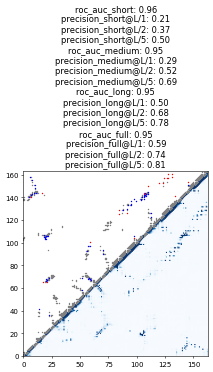

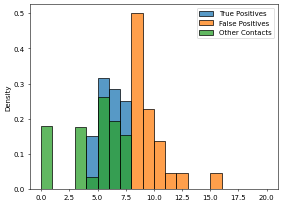

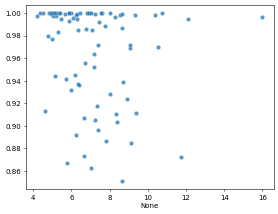

train_4J49_A


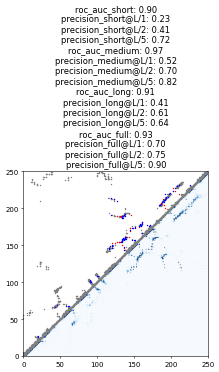

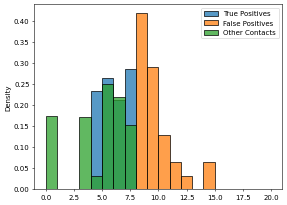

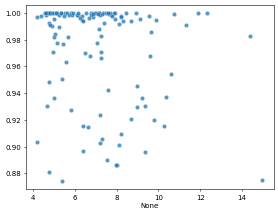

train_6PR9_A


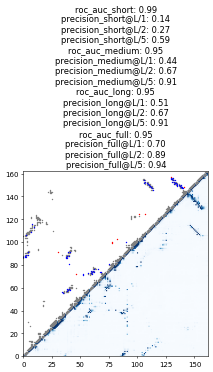

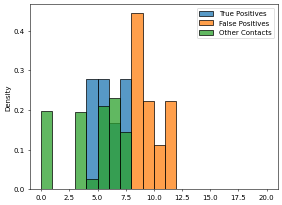

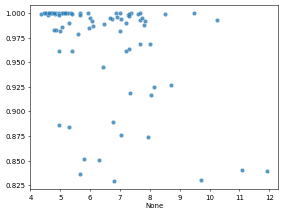

train_7OLI_A


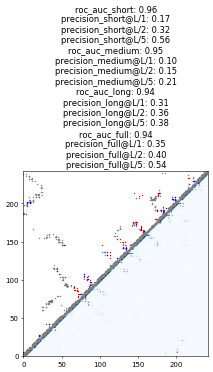

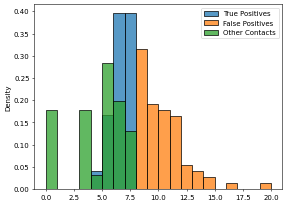

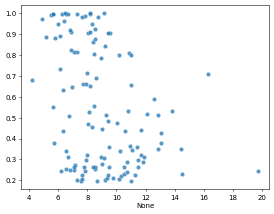

train_5TW4_A


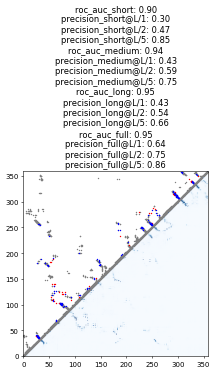

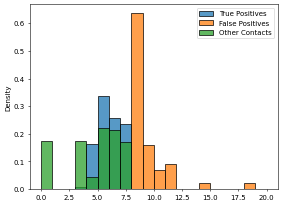

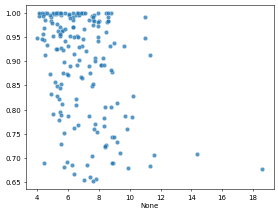

train_3LGX_C


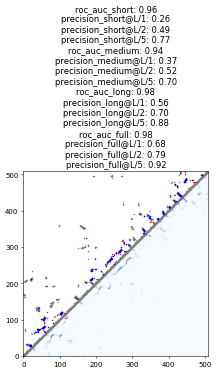

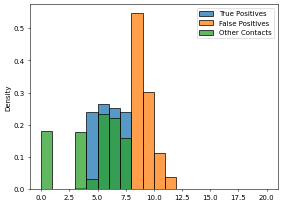

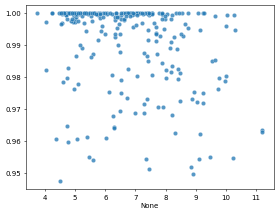

train_2I6F_B


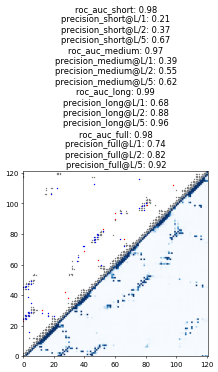

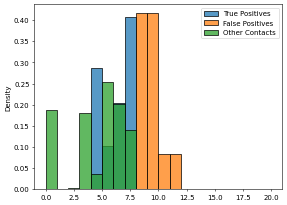

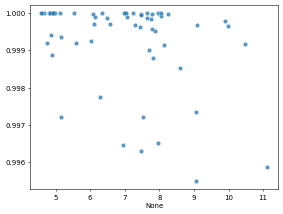

train_4K61_B


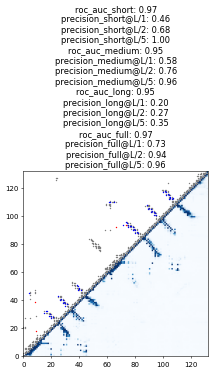

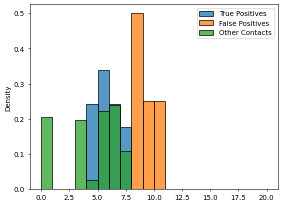

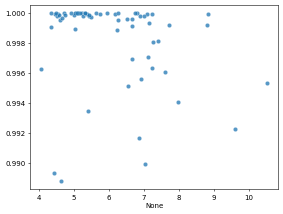

train_6BC4_A


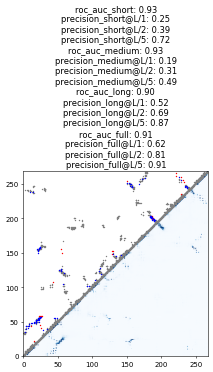

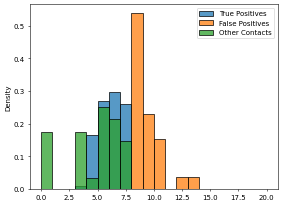

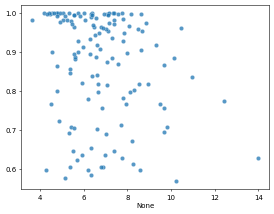

train_3A54_A


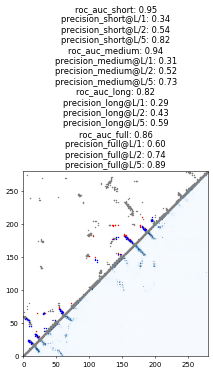

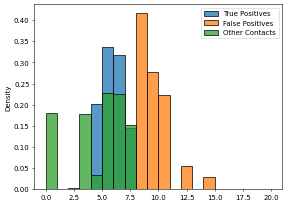

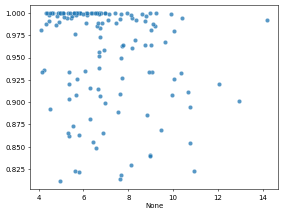

In [15]:
for id_, row in metrics.sample(10).iterrows():
    print(id_)
    plot_graphs(id_, row)


In [ ]:
clusters = pd.read_csv('../../pipeline/output/mmseqs/all_seqs_clust.tsv', sep='\t', header=None)
clusters.columns = ['cluster', 'id']
clusters.head()

,cluster,id
0,train_5ZZK_A,train_5ZZK_A
1,train_6BZQ_C,train_6BZQ_C
2,train_6BZQ_C,train_6BZQ_D
3,train_6BZQ_C,train_6BZA_A
4,train_6BZQ_C,train_6BZA_B


In [17]:
any(['1xcr' in seq_id for seq_id in clusters['id'].str.lower()])

False

In [18]:
# get sizes of clusters for each sequence
cluster_sizes = clusters.groupby('cluster').size()
id_cluster_map = clusters.set_index('id')
id_cluster_map['size'] = cluster_sizes[id_cluster_map['cluster']].values

In [19]:
id_cluster_map.sort_values(by='size', ascending=False)

,cluster,size
id,,
train_2XYU_A,train_4C3F_A,141
train_2ZYB_A,train_4C3F_A,141
train_8PQ9_A,train_4C3F_A,141
train_5FLF_E,train_4C3F_A,141
train_3CJG_A,train_4C3F_A,141
...,...,...
train_5FWH_A,train_5FWH_A,1
train_4LZI_A,train_4LZI_A,1
train_5KYG_A,train_5KYG_A,1


In [20]:
metrics['cluster_size'] = id_cluster_map.loc[metrics.index]['size']

In [21]:
metrics

,roc_auc_short,precision_short@L/1,precision_short@L/2,precision_short@L/5,roc_auc_medium,precision_medium@L/1,precision_medium@L/2,precision_medium@L/5,roc_auc_long,precision_long@L/1,precision_long@L/2,precision_long@L/5,roc_auc_full,precision_full@L/1,precision_full@L/2,precision_full@L/5,cluster_size
id,,,,,,,,,,,,,,,,,
train_1A77_A,0.898418,0.187302,0.331210,0.587302,0.968791,0.244444,0.394904,0.634921,0.884389,0.387302,0.579618,0.809524,0.905261,0.571429,0.732484,0.873016,3
train_1AQJ_A,0.929473,0.154856,0.300000,0.460526,0.951941,0.356955,0.542105,0.697368,0.972411,0.527559,0.626316,0.842105,0.968331,0.595801,0.726316,0.894737,4
train_1AQJ_B,0.929209,0.156658,0.293194,0.447368,0.948457,0.344648,0.513089,0.671053,0.973612,0.532637,0.628272,0.815789,0.968891,0.577023,0.706806,0.907895,4
train_1C1K_A,0.778583,0.078341,0.129630,0.279070,0.858808,0.041475,0.055556,0.069767,0.646087,0.023041,0.037037,0.046512,0.697244,0.087558,0.111111,0.139535,1
train_1C90_A,0.923589,0.245283,0.446970,0.698113,0.924877,0.252830,0.409091,0.566038,0.971984,0.626415,0.787879,0.924528,0.963427,0.701887,0.833333,0.962264,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_8XWK_C,0.933472,0.180723,0.322581,0.632653,0.933073,0.313253,0.516129,0.693878,0.982557,0.642570,0.830645,0.877551,0.972906,0.730924,0.838710,0.897959,13
train_8XWK_D,0.938314,0.192000,0.344000,0.660000,0.928208,0.304000,0.496000,0.680000,0.982641,0.632000,0.824000,0.900000,0.972711,0.720000,0.856000,0.880000,13
train_8Y8Y_A,0.974905,0.352313,0.578571,0.839286,0.961067,0.316726,0.457143,0.678571,0.906011,0.274021,0.407143,0.607143,0.928573,0.583630,0.792857,0.946429,1


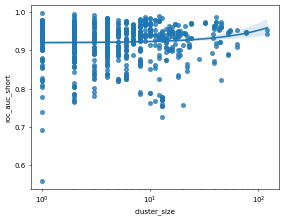

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


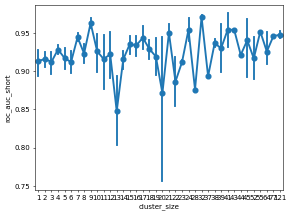

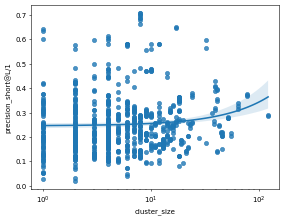

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


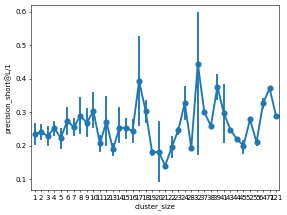

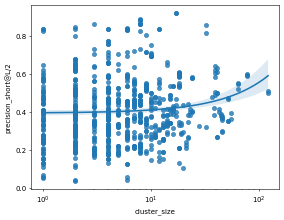

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


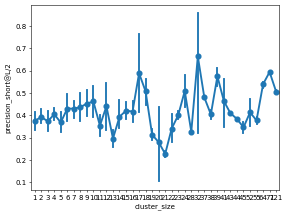

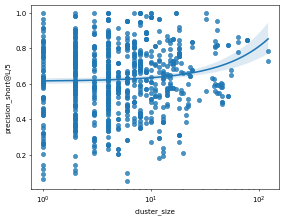

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


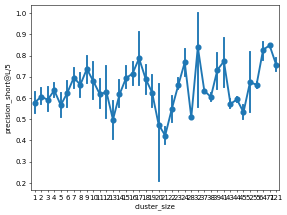

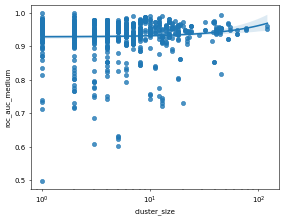

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


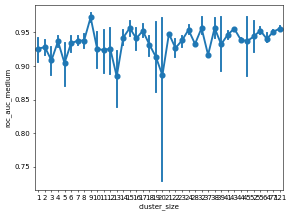

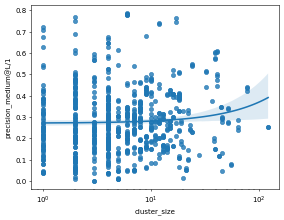

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


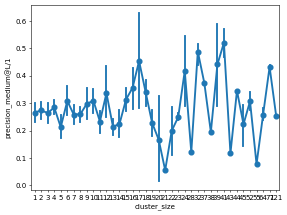

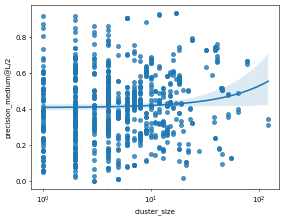

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


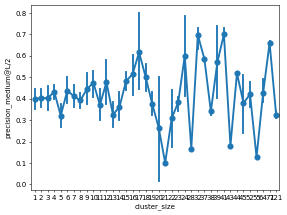

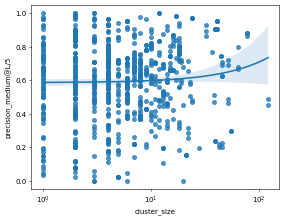

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


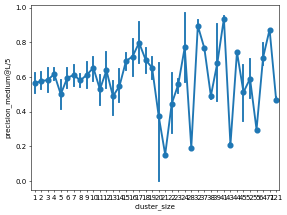

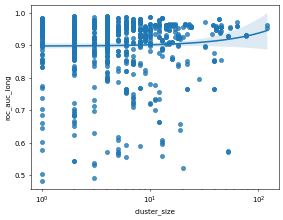

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


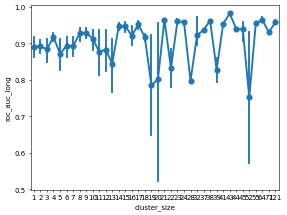

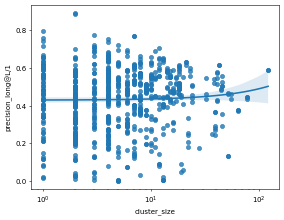

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


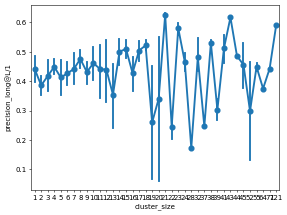

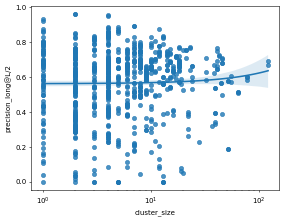

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


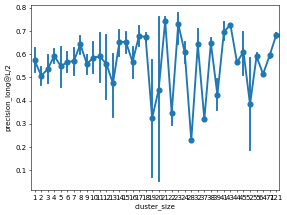

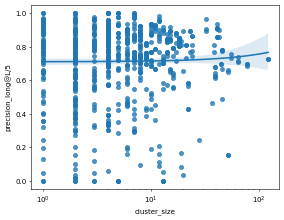

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


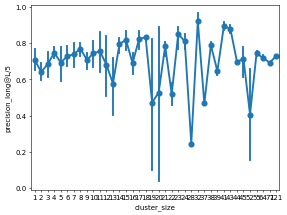

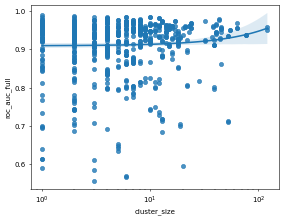

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


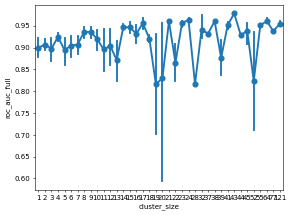

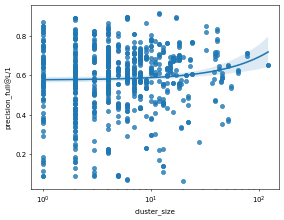

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


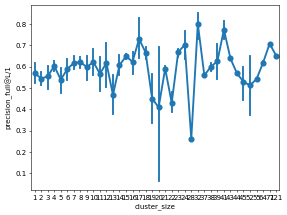

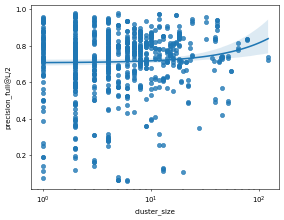

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


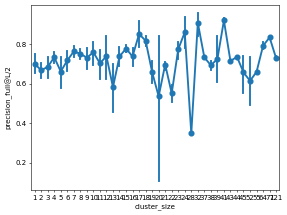

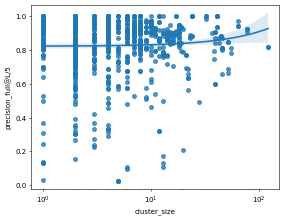

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


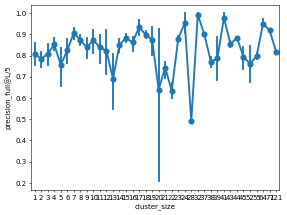

In [22]:
for col in metrics.columns:
    if col == 'cluster_size':
        continue
    sns.regplot(y=metrics[col], x=metrics['cluster_size'],)
    plt.xscale('log')
    plt.show()
    sns.pointplot(y=metrics[col], x=metrics['cluster_size'],)
    plt.show()


In [23]:
metrics

,roc_auc_short,precision_short@L/1,precision_short@L/2,precision_short@L/5,roc_auc_medium,precision_medium@L/1,precision_medium@L/2,precision_medium@L/5,roc_auc_long,precision_long@L/1,precision_long@L/2,precision_long@L/5,roc_auc_full,precision_full@L/1,precision_full@L/2,precision_full@L/5,cluster_size
id,,,,,,,,,,,,,,,,,
train_1A77_A,0.898418,0.187302,0.331210,0.587302,0.968791,0.244444,0.394904,0.634921,0.884389,0.387302,0.579618,0.809524,0.905261,0.571429,0.732484,0.873016,3
train_1AQJ_A,0.929473,0.154856,0.300000,0.460526,0.951941,0.356955,0.542105,0.697368,0.972411,0.527559,0.626316,0.842105,0.968331,0.595801,0.726316,0.894737,4
train_1AQJ_B,0.929209,0.156658,0.293194,0.447368,0.948457,0.344648,0.513089,0.671053,0.973612,0.532637,0.628272,0.815789,0.968891,0.577023,0.706806,0.907895,4
train_1C1K_A,0.778583,0.078341,0.129630,0.279070,0.858808,0.041475,0.055556,0.069767,0.646087,0.023041,0.037037,0.046512,0.697244,0.087558,0.111111,0.139535,1
train_1C90_A,0.923589,0.245283,0.446970,0.698113,0.924877,0.252830,0.409091,0.566038,0.971984,0.626415,0.787879,0.924528,0.963427,0.701887,0.833333,0.962264,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_8XWK_C,0.933472,0.180723,0.322581,0.632653,0.933073,0.313253,0.516129,0.693878,0.982557,0.642570,0.830645,0.877551,0.972906,0.730924,0.838710,0.897959,13
train_8XWK_D,0.938314,0.192000,0.344000,0.660000,0.928208,0.304000,0.496000,0.680000,0.982641,0.632000,0.824000,0.900000,0.972711,0.720000,0.856000,0.880000,13
train_8Y8Y_A,0.974905,0.352313,0.578571,0.839286,0.961067,0.316726,0.457143,0.678571,0.906011,0.274021,0.407143,0.607143,0.928573,0.583630,0.792857,0.946429,1


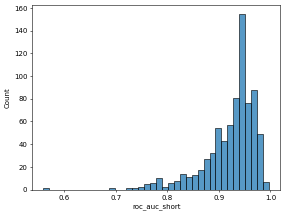

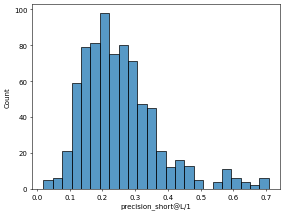

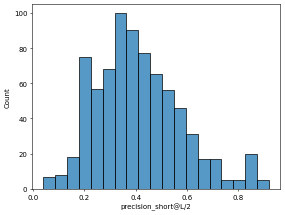

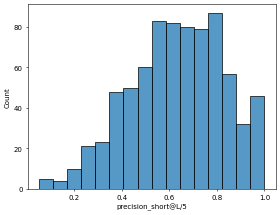

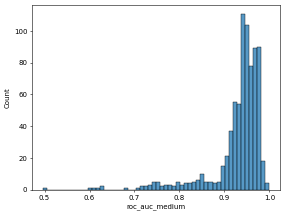

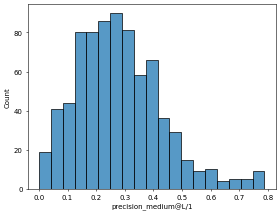

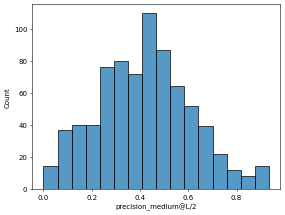

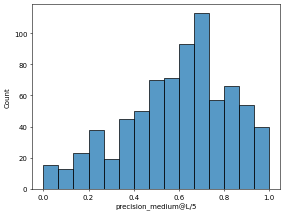

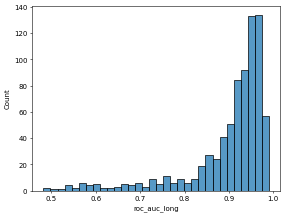

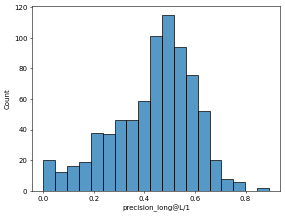

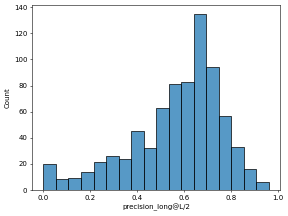

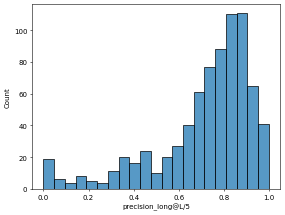

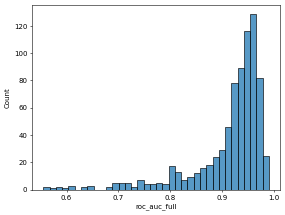

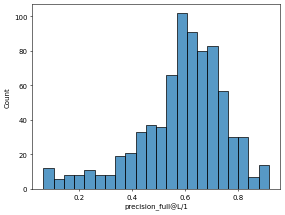

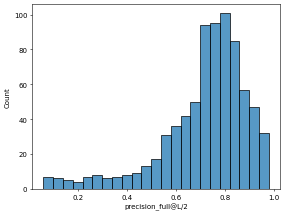

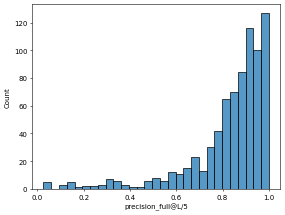

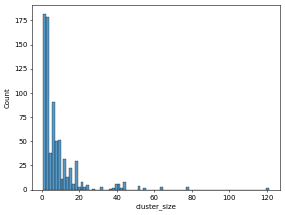

In [24]:
for metric in metrics.columns:
    sns.histplot(metrics[metric])
    plt.show()

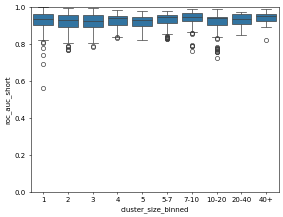

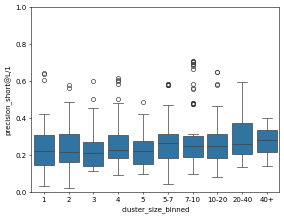

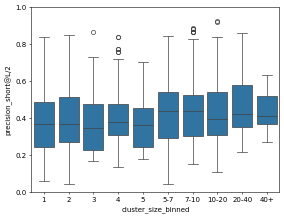

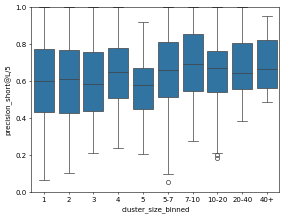

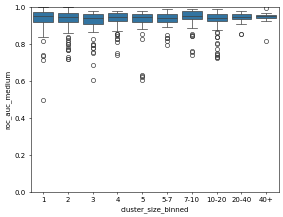

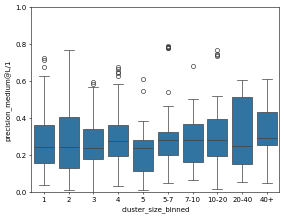

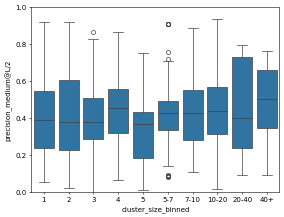

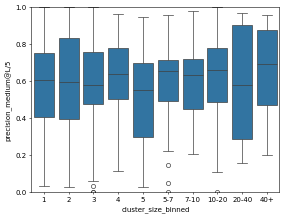

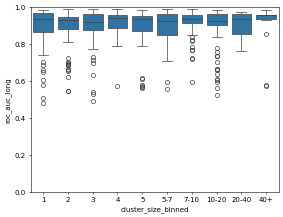

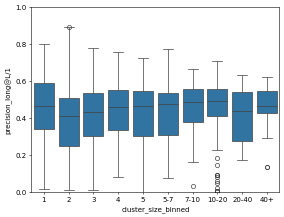

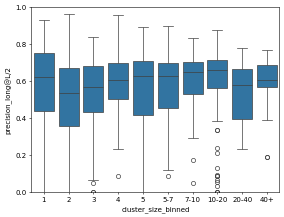

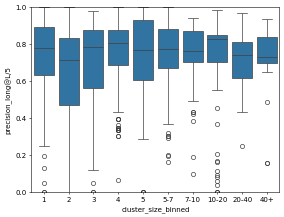

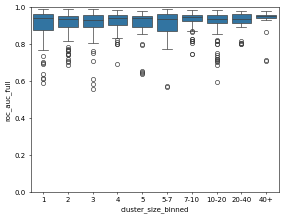

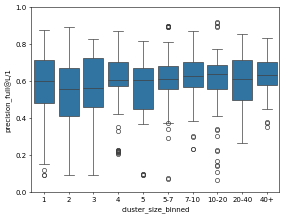

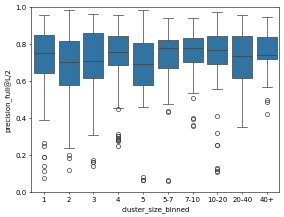

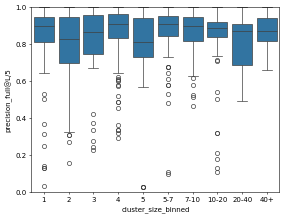

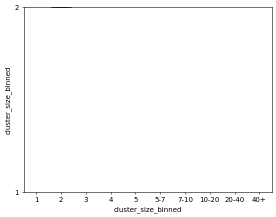

In [25]:
bins = [0,1,2,3,4,5,7,10,20,40,np.inf]
labels = ['1', '2', '3', '4', '5', '5-7', '7-10', '10-20', '20-40', '40+']
metrics['cluster_size_binned'] = pd.cut(metrics['cluster_size'], bins=bins, labels=labels)


for metric in metrics.columns:
    if metric == 'cluster_size':
        continue
    sns.boxplot(y=metrics[metric], x=metrics['cluster_size_binned'],order=labels)
    plt.ylim(0, 1)
    plt.show()